In [1]:
# NOTEBOOK IMPORTS
import os
import glob
import numpy as np
from tqdm.notebook import tqdm

# IMAGE IMPORTS
import cv2
from PIL import Image

# GIS IMPORTS
import fiona
import pyproj
from affine import Affine
from shapely.geometry import shape, mapping
from shapely.geometry import Point, LineString
from shapely.ops import transform, nearest_points, snap
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from scipy.spatial import cKDTree

# PLOTTING IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# CUSTOM UTILITIES
from WorldFileUtils import *
from GeometryUtils import *
from icp import *

Image.MAX_IMAGE_PIXELS = 933120000

In [2]:
templates_dir = "data/templates/"
tempfiles_dir = "tempfiles/"

boundary_shapefile = f"{templates_dir}HCAD_Harris_County_Boundary.shp"
boundary_points    = f'{tempfiles_dir}boundary_points.shp'

In [3]:
line = fiona.open(boundary_shapefile)

firstline = line.next()
first = shape(firstline['geometry']).boundary

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:3857')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
first = transform(project, first)

# length of the LineString
length = first.length

point_boundary_list = list()

if not os.path.exists(boundary_points):
    for distance in tqdm(range(0,int(length),5)):
        point = first.interpolate(distance)   
        point_boundary_list.append(point)
        point_boundary_gdf = gpd.GeoDataFrame(geometry=point_boundary_list)
        point_boundary_gdf.to_file(boundary_points)
    else:
        point_boundary_gdf.read_file(boundary_points)

C:\Users\franc\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/94959 [00:00<?, ?it/s]

In [5]:
# BOUNDARY SHAPEFILE AND BUFFER
boundary_shp = gpd.read_file(boundary_shapefile).to_crs("EPSG:3857")
boundary_buf = boundary_shp.boundary.buffer(1000)

# PIXEL COORDINATES FROM TILE
coords = get_true_pixel_coordinates(f"{tempfiles_dir}border.png", polygon=boundary_buf)
coords_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(coords[:, 0], coords[:, 1]))

coords_full = get_true_pixel_coordinates(f"{tempfiles_dir}border.png")
coords_full_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(coords_full[:, 0], coords_full[:, 1]))

# PIXEL COORDINATES FROM CLOSEST POINT IN LINE
boundary_line = LineString(point_boundary_gdf.geometry)
boundary_points_matching = find_points_on_linestring(boundary_line, coords_gdf.geometry)

boundary_points_matching_gdf = gpd.GeoDataFrame(geometry=boundary_points_matching)

  0%|          | 0/39616 [00:00<?, ?it/s]

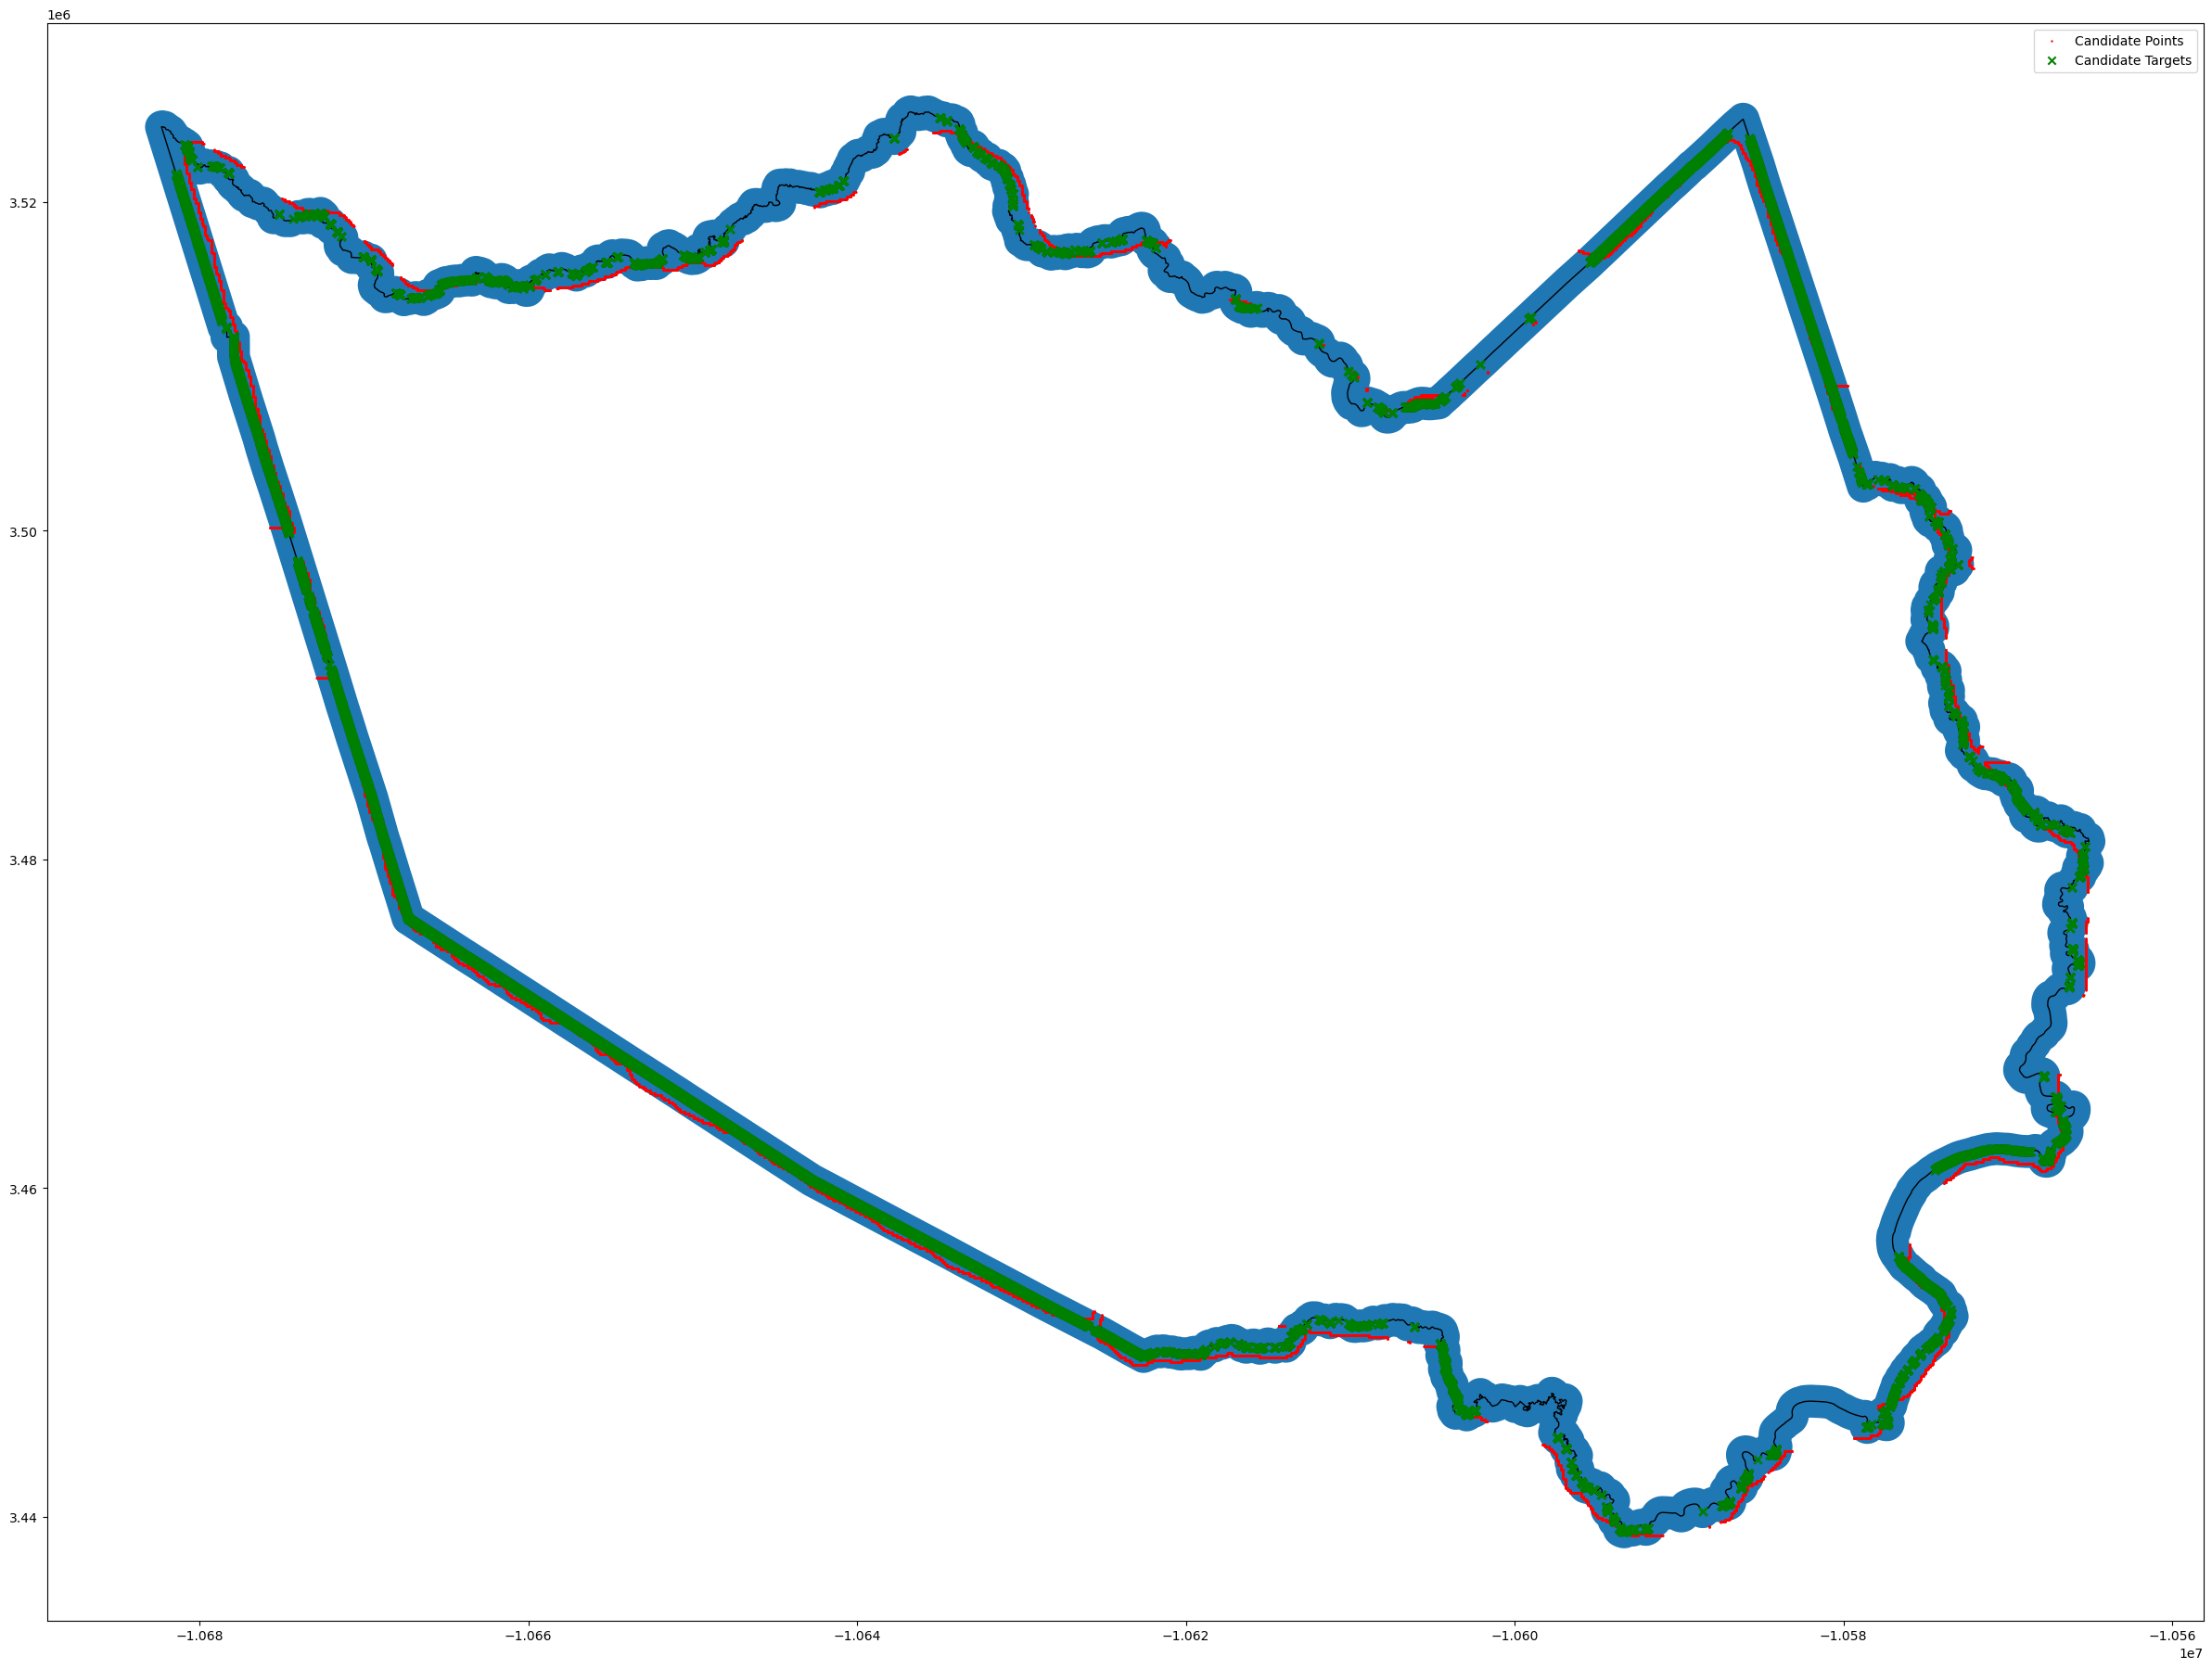

In [6]:
fig, ax = plt.subplots(figsize=(30, 30))
boundary_buf.plot(ax=ax, label="Zone of Interest for Candidate Points")
boundary_shp.plot(ax=ax, color="None", edgecolor='black', label="True Boundary")
coords_gdf.plot(ax=ax, marker='.', color='red', markersize=2, label="Candidate Points")
boundary_points_matching_gdf.plot(ax=ax, marker='x', color="green", label="Candidate Targets")
ax.legend()

In [7]:
boundary_points_matching_coords = np.array([np.array([m.x, m.y]) for m in boundary_points_matching])

to_points = np.array(boundary_points_matching_coords).astype(np.int64)
from_points = np.array([np.array([cg.x, cg.y]).astype(np.int64) for cg in coords_gdf.geometry])

In [8]:
test = cv2.findHomography(from_points, to_points, cv2.RANSAC,5.0)
# test = cv2.getAffineTransform(from_points.astype(np.float32), to_points.astype(np.float32))

In [9]:
points_to_project = np.vstack((coords_full_gdf.geometry.x.to_numpy().T, coords_full_gdf.geometry.y.to_numpy().T)).T
homography = test[0]

In [10]:
points_to_project_homogeneous = np.hstack((points_to_project, np.ones((points_to_project.shape[0], 1))))
# Project the points using the homography matrix
projected_points_homogeneous = np.dot(homography, points_to_project_homogeneous.T).T

# Convert homogeneous coordinates to Cartesian coordinates
projected_points = (projected_points_homogeneous[:, :2] / projected_points_homogeneous[:, 2:]).astype(np.int)

C:\Users\franc\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [11]:
projected_geometries = [Point(x, y) for x, y in projected_points]
projected_gdf = gpd.GeoDataFrame(geometry=projected_geometries)

<AxesSubplot:>

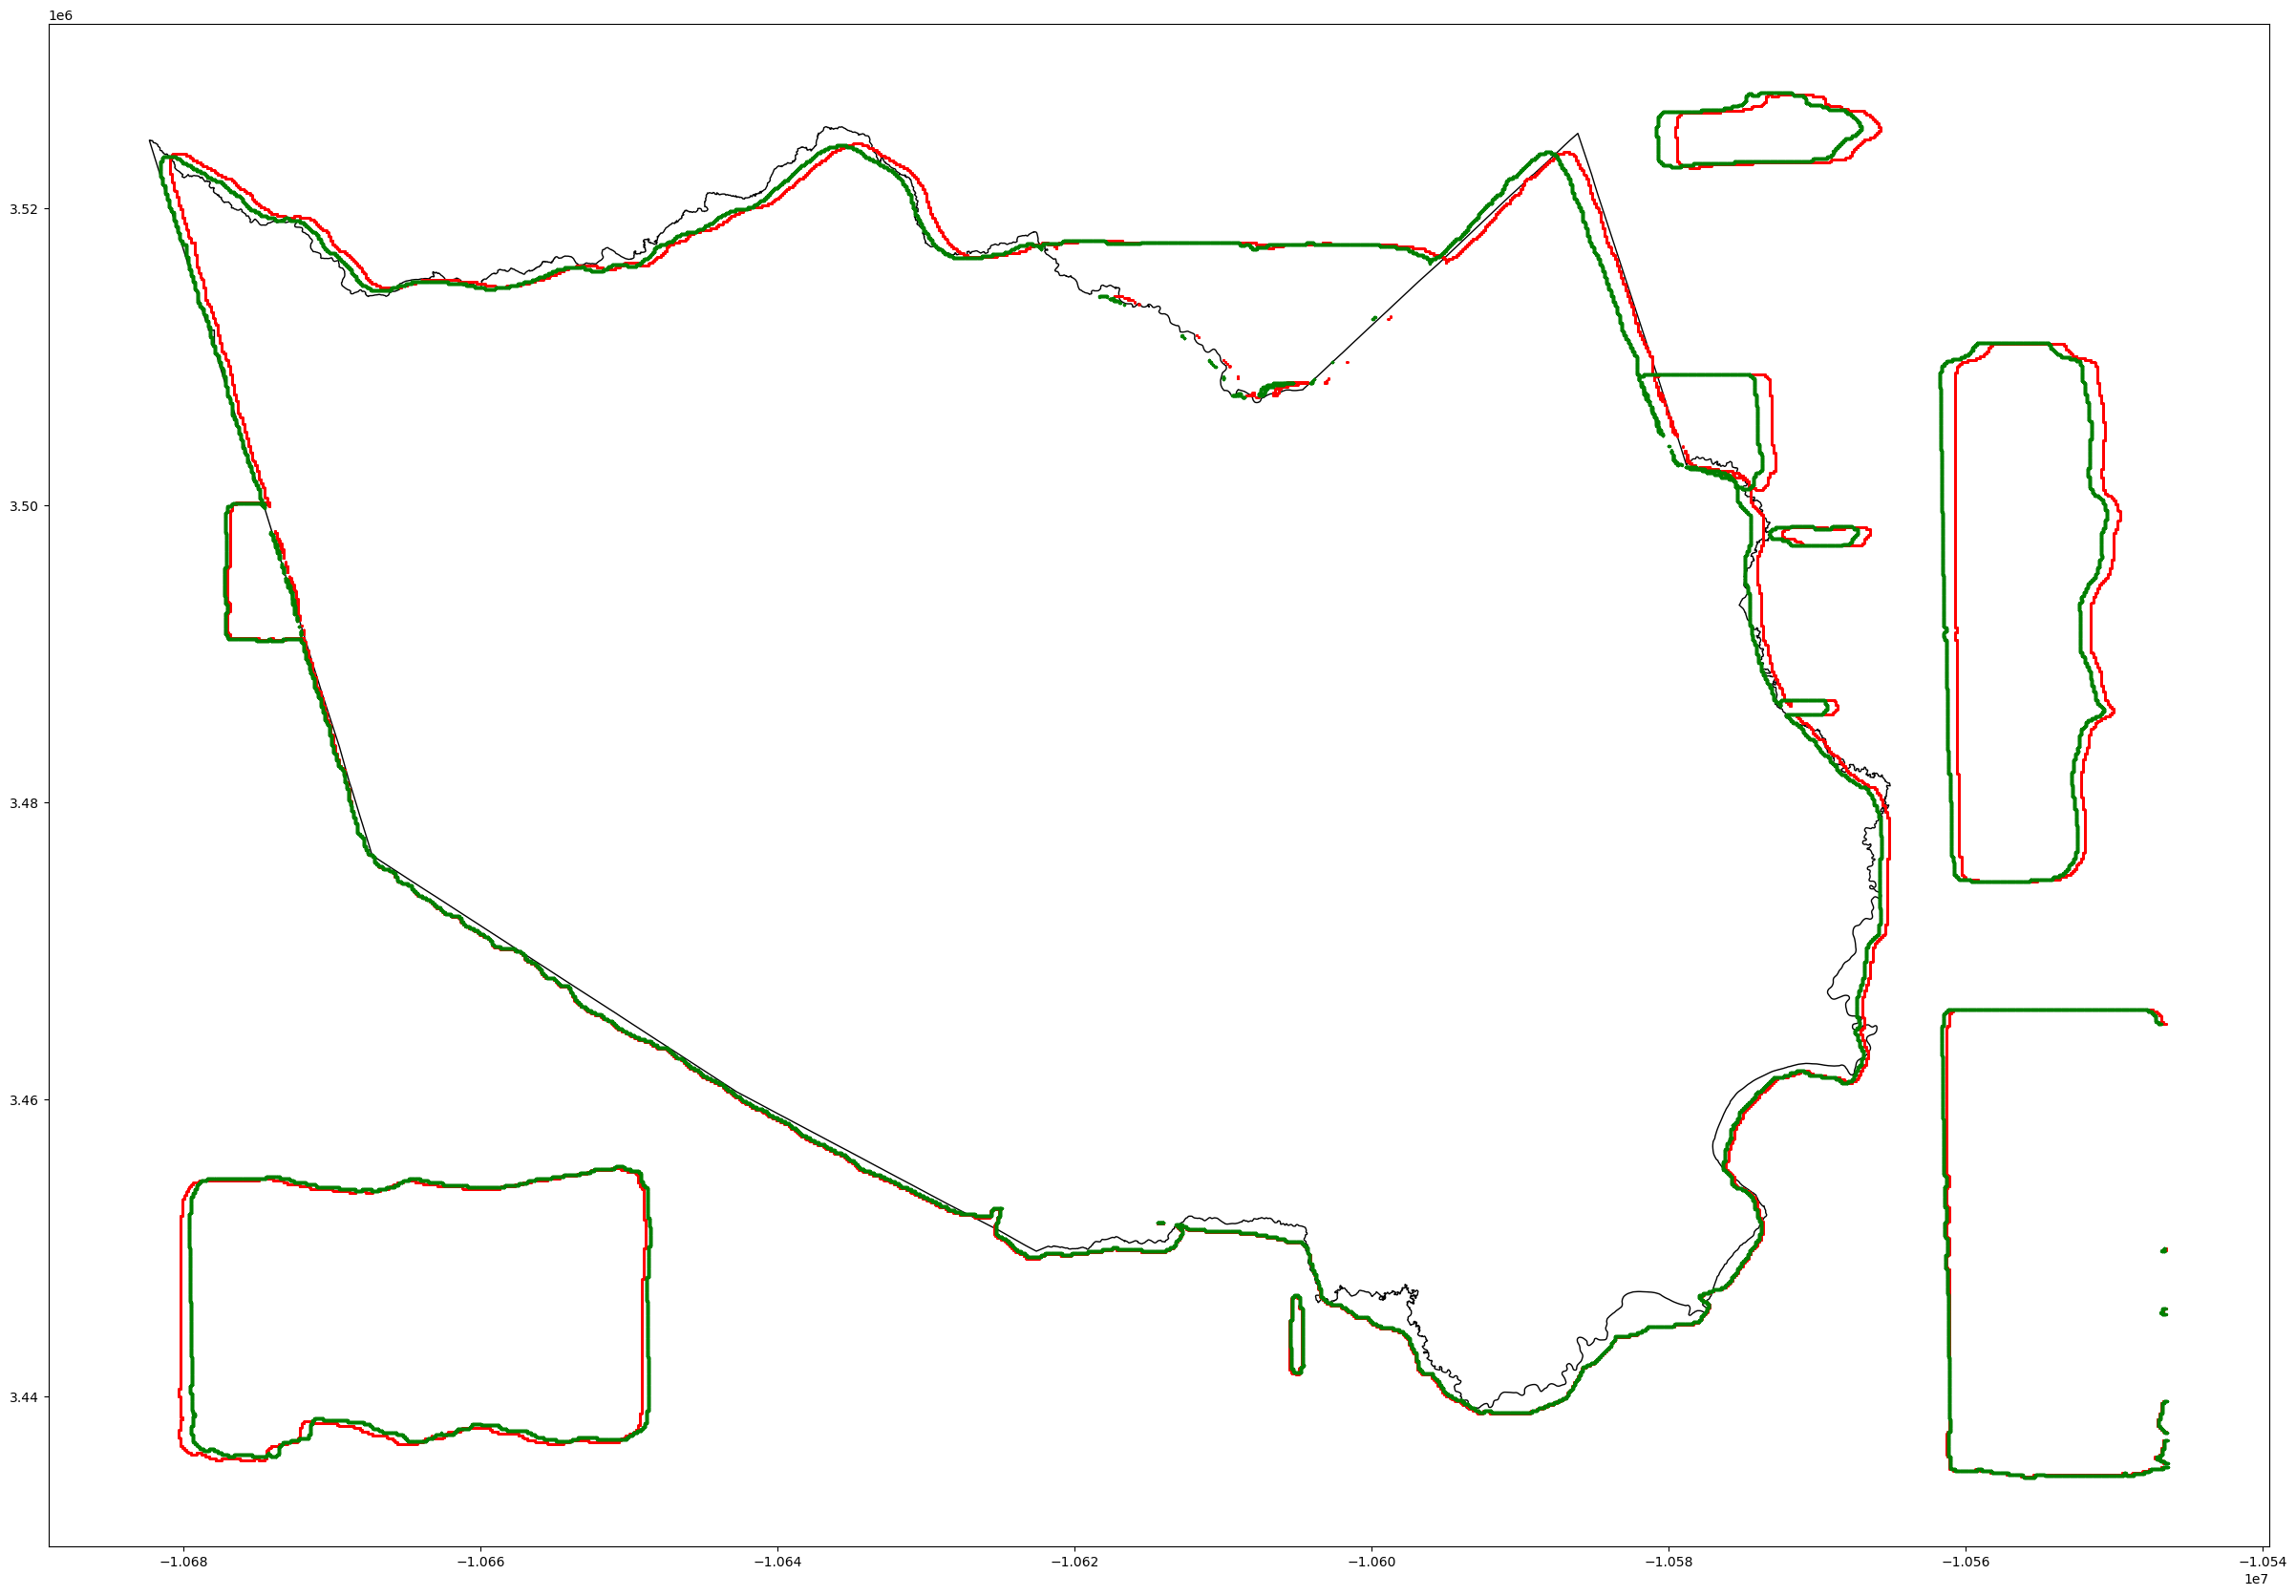

In [13]:
fig, ax = plt.subplots(figsize=(30, 30))
# boundary_buf.plot(ax=ax)
boundary_shp.plot(ax=ax, color="None", edgecolor='black')
coords_full_gdf.plot(ax=ax, marker='.', color='red', markersize=2)
# boundary_points_matching_gdf.plot(ax=ax, marker='x', color="green")
projected_gdf.plot(ax=ax, marker='x', color="green", markersize=2)